In [1]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil

import time

import scipy.io as io
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
#import jax.profiler # !
#server = jax.profiler.start_server(port=1234)

from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc
import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
import utils
from utils import *

In [3]:
# load the data from the SuiteSparse Matrix Collection format
#   https://www.cise.ufl.edu/research/sparse/matrices/
#graph_name = 'qh882'
graph_name = 'dwt_1005'
#graph_name = '3elt'
#graph_name = 'bcsstk31'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
#fig1, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,20))
#ax1.imshow(graph.todense()!=0, cmap='gray')
#ax1.set_title("adjacency")
#graphdist = csgraph.shortest_path(graph, directed=False, unweighted=True)
#ax2.set_title("graph distances")
#ax2.imshow(graphdist, cmap='gray')

In [4]:
G = nx.from_numpy_matrix(graph.toarray().astype(int)!= 0, create_using=None)
A = nx.adjacency_matrix(G).toarray().astype(np.int16)
L = csgraph_laplacian(A, normed=False).astype(np.float32)
D = np.diag(np.sum(A, axis=1)).astype(np.int16)
n = L.shape[0]
n

1005

In [5]:
del G
del A
del D
del mat_data

Objective and constraints

$f(x, y) = x^TAx + y^TAy + 2b^Tx + 2d^Ty$ 

$g(x, y) = [v^Tx, v^Ty]$ 

$h(x, y) = [x^TDx - c_1, y^TDy - c_2, 2(x^TDy - c_3)]$

In [6]:
@jit
def f(X, A_x, A_y, b_x, b_y):
    obj= X[:,0].T@A_x@X[:,0] + X[:,1].T@A_y@X[:,1] + 2*b_x.T@X[:,0] + 2*b_y.T@X[:,1]
    return obj.real

@jit
def f_l(X, L, C, A_x, A_y, b_x, b_y):
    obj = jnp.trace(jnp.inner(X, A_x@X + 2*jnp.stack([b_x,b_y],axis=1))) + jnp.trace(jnp.inner(L, X.T@X - C))
    return obj.real

@jit
def foc_pgd(X, L, C, A, b_x, b_y):
    obj = jnp.linalg.norm((A + L[0,0]*jnp.eye(A.shape[0]))@X[:,0] + L[1,0]*X[:,1] + b_x) + \
    jnp.linalg.norm((A + L[1,1]*jnp.eye(A.shape[0]))@X[:,1] + L[1,0]*X[:,0] + b_y)
    return obj.real

@jit
def foc_sqp(X, L, C, A, E_0):
    obj = A@X + E_0 + X@L
    return jnp.linalg.norm(obj.real)

def g(X, v, c):
    return np.array([v.T@X[:,0], v.T@X[:,1]]) - c

def h(X, D, c1, c2, c3, c=jnp.array([0,0])):
    return np.array([(X[:,0]-c[0]).T@D@(X[:,0]-c[0]) - c1, 
                     (X[:,1]-c[1]).T@D@(X[:,1]-c[1]) - c2, 
                     2*((X[:,0]-c[0]).T@D@(X[:,1]-c[1]) - c3)])

@jit
def L_init(X_k, C, A, E_0):
    return (jnp.linalg.inv(C)@X_k.T@(A@X_k+E_0)).astype(jnp.float32)

Projection

$X = [X_1]_+ = X_1C_1^{-1/2}UV^TC^{1/2}$

where $C_1 = X_1^TX_1$, $C = X^TX$, and $U\Sigma V^T = C^{1/2}C_1^{1/2}$

In [7]:
@jit
def project(X1, C, E_0, c=jnp.array([0,0])):
    C1 = X1.T@X1
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,s,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt

    # default to this unless not improve cost
    # normalized v as Q
    negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 0)
    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = jax.lax.cond(negdef,
                     lambda _ : X@(-U_E@V_E.T),
                     lambda _ : X,
                     operand=None
                    )
    return X.real

In [8]:
@jit
def _step_noautograd(stp, X_k, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    E_0 = stp*jnp.vstack([b_x,b_y]).T
    X_k_x = X_k[:,0] - stp*A_x@X_k[:,0]
    X_k_y = X_k[:,1] - stp*A_y@X_k[:,1]
    X_k_t = jnp.vstack([X_k_x,X_k_y]).T - E_0
    #X_k_t = project(X_k_t, C)
    X_k_t = project(X_k_t, C, E_0)
    return X_k_t

def pgd(X_k, A_x, A_y, b_x, b_y, C, convergence_criterion, 
           maxiters=1000, alpha=1e-2, beta=0.9):
    """Perform iterations of PGD, without autograd."""
    loss = []
    param_hist  = []
    grad_hist = []
    E_0 = jnp.stack([b_x, b_y], axis=1)
    L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
    Ls = [L]
    
    for k in tqdm(range(maxiters)):
        # backtracking line search
        f_xp = 1e8
        stp = 1

        f_x = f(X_k, A_x, A_y, b_x, b_y)
        X_k_t = X_k
        derphi=1
        while f_xp >= f_x - alpha * stp * derphi:
            stp *= beta
            X_k_t = _step_noautograd(stp, X_k, A_x, A_y, b_x, b_y)    
            f_xp = f(X_k_t, A_x, A_y, b_x, b_y)
        
            if stp < 1e-6:
                break  
        if len(loss) > 1 and np.abs(f_x - loss[-1]) <= convergence_criterion:
            break
        #step_sizes.append(stp)
        X_k = X_k_t
        param_hist.append(X_k)
        loss.append(f_x) 
        L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
        Ls.append(L)
        #grad_hist.append(jnp.linalg.norm(f_l_sqp(X_k, -L, C, A_x, E_0)))
        grad_hist.append(foc_pgd(X_k, L, C, A_x, b_x, b_y))
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'foc':grad_hist, 'ext_data':{'L':Ls}}

@jit
def step(i, opt_state, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    p = get_params(opt_state)
    g = grad(f)(p, A_x, A_y, b_x, b_y)
    return opt_update(i, g, opt_state)

def pgd_autograd(opt_params, A_x, A_y, b_x, b_y, C, convergence_criterion, maxiters=1000):
    """Perform iterations of PGD, with autograd """
    opt_state, opt_update, get_params = opt_params
    E_0 = jnp.stack([b_x, b_y], axis=1)
    X_k = get_params(opt_state)
    loss = [f(X_k, A_x, A_y, b_x, b_y)]
    L = jnp.eye(2)
    Lh = [L]
    param_hist  = [X_k]
    grad_hist= [foc_pgd(X_k, L, C, A_x, b_x, b_y)]
    for k in tqdm(range(maxiters)):
        opt_state = step(k, opt_state, A_x, A_y, b_x, b_y)
        X_k = get_params(opt_state)
        param_hist.append(X_k)
        l = f(X_k, A_x, A_y, b_x, b_y)
        
        assert not np.isnan(l)
        
        if len(loss) > 1 and np.abs(l - loss[-1]) <= convergence_criterion:
            break
        loss.append(l)

        L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
        Lh.append(L)
        #grad_hist.append(jnp.linalg.norm(f_l_sqp(X_k, -L, C, A_x, E_0)))
        #grad_hist.append(foc_sqp(X_k, L, C, A, E_0))
        grad_hist.append(foc_pgd(X_k, L, C, A_x, b_x, b_y))
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'foc':grad_hist, 'L':Lh}

@jit
def _step(i, opt_state, Z):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

def D_Z(X, A, d, e):
    I = jnp.eye(A.shape[0])
    Adinv = jnp.linalg.inv(A + d*I)
    XtADinv = X.T@Adinv
    Del = jnp.linalg.inv(XtADinv@X)@XtADinv@e
    Z = Adinv@(-X@Del + e)
    
    return Del, Z

def _D_Z(X, A, P, d, e):
    I = jnp.eye(A.shape[0])
    Adinv = jnp.linalg.inv(A + d*I)
    XtADinv = X.T@Adinv
    Del = jnp.linalg.inv(XtADinv@X)@XtADinv@e
    
    Z = P@Adinv@P@(-X@Del + e)
    
    return Del, Z

@jit
def _sqp(A, A_L, P, L, E_0, X):
    I = jnp.eye(A.shape[0])
    w = jnp.linalg.eigvals(L)
    idx = w.argsort()[::-1]   
    w = w[idx]
    E = -E_0 - (A@X + X@L)
    
    Del_0, Z_0 = _D_Z(X, A_L, P, w[0], E[:,0])
    Del_1, Z_1 = _D_Z(X, A_L, P, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del 

@jit
def sqp(A, L, E_0, X):
    I = jnp.eye(A.shape[0])
    w = jnp.linalg.eigvals(L)
    idx = w.argsort()[::-1]   
    w = w[idx]
    E = -E_0 - (A@X + X@L)
    
    Del_0, Z_0 = D_Z(X, A, w[0], E[:,0])
    Del_1, Z_1 = D_Z(X, A, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del    

"""Perform iterations of PND + backtracking line search."""
def newton(opt_params, A, A_L, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9):
    
    opt_state, opt_update, get_params = opt_params

    loss = [f(X_k, A, A, b_x, b_y)]
    param_hist  = []
    descent_hist = []
    
    E_0 = np.stack([b_x, b_y], axis=1)
    L = L_init(X_k, C, A, E_0)
    #L = jnp.linalg.inv(C)@X_k.T@(A@X_k+E_0)
    #L_sym = (L + L.T)/2
    #L = L_sym
    
    X_k = get_params(opt_state)
    
    grad_hist= []
    hess_hist = []
    
    step_sizes = []
    
    data = {'L':[], 'gradcorr':[], 'stp':[], 'dec':[], 'pre_proj':[]}
    for k in tqdm(range(maxiters)):         
        #Z, Del = sqp(A, L, E_0, X_k)
        Z, Del = _sqp(A, A_L, P, L, E_0, X_k)
        
        # backtracking line search
        f_xp = 1e8
        stp = 1
        f_x = f(X_k, A, A, b_x, b_y)
        derphi = 1
        #f_x, gr = value_and_grad(f)(X_k, A, A, b_x, b_y)
        #derphi = jnp.trace(gr.T@Z)
        len_p = jnp.linalg.norm(Z)
        X_k_t = X_k
        
        opt_state_t = opt_state
        
        while f_xp >= f_x:# - alpha * stp * derphi:
            stp *= beta
            opt_state_t = _step(stp, opt_state, -Z)
            X_k_t = get_params(opt_state_t)
            f_xp = f(X_k_t, A, A, b_x, b_y)
        
            if stp * len_p < 1e-8:
                break       
        step_sizes.append(stp)
        L = L + stp*Del
        
        opt_state = opt_state_t
        X_k = get_params(opt_state_t)
     
        param_hist.append(X_k)
        grad_hist.append(foc_sqp(X_k, L, C, A, E_0))
        
        if len(loss) > 1 and np.abs(f_xp - loss[-1]) <= convergence_criterion:
            break
            
        loss.append(f_x)
        data['gradcorr'].append(derphi)
        data['L'].append(L)
        data['stp'].append(stp)
        data['dec'].append(Z)
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'ext_data':data, 
            'foc':grad_hist, 'step_sizes':step_sizes}
    
def ssm():
    """
    1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    """
    pass

In [9]:
def map_vars(A, X_k, fixed_indices, centercons):
    N = A.shape[0] 
    k = fixed_indices.shape[0]
    fixed_idx = np.zeros((k,N))
    for i in range(k):
        fixed_idx[i,fixed_indices[i]] += 1
    if k>0:
        fixed_coordsx = X_k[fixed_indices,0]
        fixed_coordsy = X_k[fixed_indices,1]
        
        constraints = np.concatenate([fixed_idx,np.expand_dims(1-fixed_idx.sum(0),0)])
        fixed_coordsx = np.concatenate([fixed_coordsx,np.expand_dims(centercons[0],0)])
        fixed_coordsy = np.concatenate([fixed_coordsy,np.expand_dims(centercons[1],0)])
        P = null_space(constraints).T
        #_,P = qr_null(constraints)
        #P = P.T
        #print(P.shape)
        
        pinvcons = np.linalg.pinv(constraints)
        
        n0_x = (pinvcons@fixed_coordsx)
        b_x = (P@(A@n0_x))
        
        n0_y = (pinvcons@fixed_coordsy)
        b_y = (P@(A@n0_y))
        A = (P@A@P.T)
    else:
        constraints = np.expand_dims(np.ones(n),0)    
        P = null_space(constraints).T
        #P = np.ones((constraints[0],))/n
        #_,P = qr_null(constraints)
        #P = P.T
        pinvcons = np.linalg.pinv(constraints)
        n0_x = pinvcons@(np.expand_dims(centercons[0],0))
        b_x = P@(A@n0_x)

        n0_y = pinvcons@(np.expand_dims(centercons[1],0))
        b_y = P@(A@n0_y)
        
        A = P@A@P.T 
        
    return A, P, b_x, b_y, n0_x, n0_y, fixed_idx

def cluster(rng, opt_params, X_k, A, mapped_vars, fixed_indices, maxiters=1000, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    
    global opt_update
    assert method in ['pgd','pnd','ssm']
    assert len(A.shape) == 2
    assert A.shape[0] == X_k.shape[0]
    
    k = fixed_indices.shape[0]
    fixed_coordsx = X_k[fixed_indices,0]
    fixed_coordsy = X_k[fixed_indices,1]

    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    if D is None:
        D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)
    A_L = A
    A, P, b_x, b_y, n0_x, n0_y, fixed_idx = mapped_vars

    C = jnp.block([[c1, c3],[c3, c2]])

    assert jnp.linalg.det(C) > 1e-5
    E_0 = jnp.stack([b_x, b_y], axis=1)
    
    n0 = jnp.stack([n0_x,n0_y],axis=0)
    X_k_n = jnp.array(np.linalg.pinv(P.T)@(X_k-n0.T))
    X_k_n = project(X_k_n, C, E_0, centercons)
    L = np.eye(2)
    
    #A = A.astype(jnp.float32)
    
    if method == "pgd":
        #opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y, z: project(z, x, y), C, centroid), 
        #                                     b1=0.9, b2=0.999, eps=1e-08)
        #opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y, z: project(z, y, x), 
        #                                            np.stack([b_x,b_y],axis=1), C), b1=0.9, b2=0.999, eps=1e-08)
        opt_init, opt_update, get_params = opt_params
        opt_state = opt_init(X_k_n)
        A_x = A
        A_y = A

        #result = pgd_autograd((opt_state, opt_update, get_params), A_x, A_y, b_x, b_y, C, 
        #                      convergence_criterion=convergence_criterion, maxiters=maxiters) 

            
        result = pgd(X_k_n, A_x, A_y, b_x, b_y, C, 
                        convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.5, beta=0.9)  
    elif method == "pnd":
        opt_init, opt_update, get_params = opt_params
        opt_state = opt_init(X_k_n)
        result = newton((opt_state, opt_update, get_params), A, A_L, L, C, X_k_n, b_x, b_y, 
                        convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.0, beta=0.9)        
    else:
        print("method not supported")
        return 1
    X_k = result['sln_path'][np.argmin(result['lossh'])]
    X_k = project(X_k_n, C, E_0, centercons)
    X_k_n = np.zeros((N,2))
    X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
    X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
        
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(np.bool)
    result['mask'] = mask
    result['centroid'] = centercons
    if fixed_idx.sum() == 0:
        result['g'] = g(X_k_n, v, centercons)
        result['h'] = h(X_k_n, np.diag(v), c1, c2, c3, centroid)        
    else:
        result['g'] = g(X_k_n[mask], v[mask], centercons)
        result['h'] = h(X_k_n[mask], np.diag(v[mask]), c1, c2, c3, centroid)
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)
    
    return result

In [10]:
method = "pnd" # pnd or pgd
seed = 0
eps = 1e-8
alpha = 5e-3
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))

w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM')

#w = np.load('bcsstk31_evals.npy')
#v = np.load('bcsstk31_evecs.npy')

#idx = w.argsort()[::-1]   
#w = w[idx]
#v = v[:,idx]
X_k = v[:,1:3]

fixed_indices = np.array([1,2,3,4,5,6,7,8,9,10])
#fixed_indices = np.array([])
X_k[fixed_indices] = X_k_r[fixed_indices]
#X_k = X_k_r
#X_k = pgd_soln

#X_k = X_k.astype(jnp.float16)
#L = L.astype(jnp.int16)

In [11]:
"""
w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM')
i = -2
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
print(np.linalg.norm(L@v[:,i] - w[i]*v[:,i]))
"""

"\nw,v = sp.sparse.linalg.eigsh(L, k=5, which='SM')\ni = -2\nidx = w.argsort()[::-1]   \nw = w[idx]\nv = v[:,idx]\nprint(np.linalg.norm(L@v[:,i] - w[i]*v[:,i]))\n"

In [12]:
del w
del v
del X_k_r
v = jnp.ones(n)
A, P, b_x, b_y, n0_x, n0_y, fixed_idx = map_vars(L, X_k, fixed_indices, v.sum()*jnp.array([0,0]))

mapped_vars = (A, P, b_x, b_y, n0_x, n0_y, fixed_idx)

#print(P.shape)
if method == "pgd":
    # 5e-2
    pgd_lr = 5e-2
    #opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C), b1=0.9, b2=0.999, eps=1e-08)

elif method == "pnd":
    opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C))

In [13]:
#np.savez('bcsstk31_mapped_vars.npz', *[A, P, b_x, b_y, n0_x, n0_y, fixed_idx])

In [14]:
#np.save('bcsstk31_evals.npy', w)
#np.save('bcsstk31_evecs.npy', v)

In [15]:
#%prun -s cumulative cluster(rng, (opt_init, opt_update, get_params),X_k, L, mapped_vars, fixed_indices=fixed_indices,c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), v=None, D=None, eps=1e-8, maxiters=2000, convergence_criterion=1e-3, method=method)
result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, L, mapped_vars, fixed_indices=fixed_indices,c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=1000, convergence_criterion=1e-4, method=method)
results = [result]

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: dot_general requires contracting dimensions to have the same shape, got [994] and [1005].

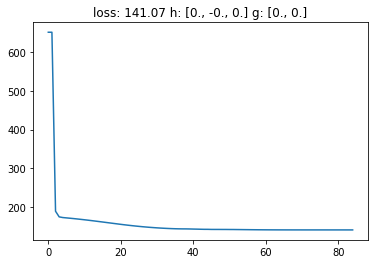

In [16]:
X_k_n=result['x']
loss = result['lossh'][:np.argmin(result['lossh'])]
param_hist = result['sln_path']

gc = result['g']
hc = result['h']
plt.plot(loss)
#plt.title('loss: {} h: {} g: {}'.format(str(np.round(np.min(result['lossh']),2)), np.round(hc,2), np.round(gc,2)))
plt.title('loss: {} h: [0., -0., 0.] g: [0., 0.]'.format(str(np.round(loss[-1],2))))
plt.show()

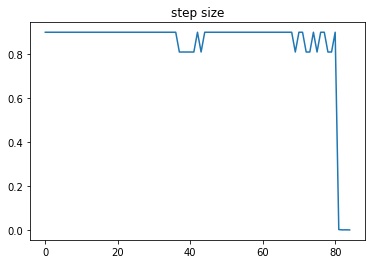

In [17]:
if 'step_sizes' in result:
    plt.plot(result['step_sizes'][:np.argmin(result['lossh'])])
    plt.title('step size')

Text(0.5, 1.0, 'initial foc: 4.372, final foc: 0.023')

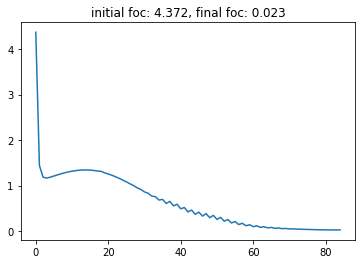

In [18]:
plt.plot(result['foc'][:np.argmin(result['lossh'])])
plt.title('initial foc: {:.3f}, final foc: {:.3f}'.format(result['foc'][0], result['foc'][-1]))

Text(0.5, 1.0, '[LOG foc] initial foc: 1.475, final foc: -3.757')

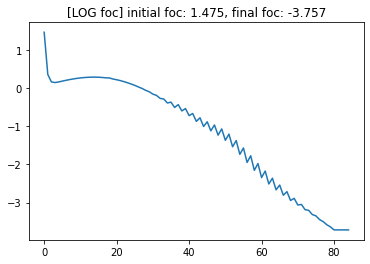

In [19]:
plt.plot(np.log(result['foc'][:np.argmin(result['lossh'])]))
plt.title('[LOG foc] initial foc: {:.3f}, final foc: {:.3f}'.format(np.log(result['foc'][0]), np.log(result['foc'][-1])))

In [26]:
pap = result['P']@L@result['P'].T
print(result['ext_data']['L'][-1].real,
np.linalg.eig(result['ext_data']['L'][-1])[0].real, 
np.sort(np.linalg.eig(pap)[0])[:6].real,
1.0 - ( np.count_nonzero(pap) / float(pap.size) ), 1.0 - ( np.count_nonzero(L) / float(L.size) ))

[[-0.00396271 -0.00153991]
 [-0.00154466 -0.00373271]] [-0.00539427 -0.00230115] [0.00232606 0.00564505 0.00739835 0.0093147  0.01091754 0.01305648] 0.0 0.9985562697500718


In [ ]:
#np.savetxt('_12',result['ext_data']['dec'][12].real,fmt='%.3e')

In [ ]:
print(np.linalg.eig(result['ext_data']['L'][9])[0].real, 
np.linalg.eig(result['ext_data']['L'][10])[0].real,
np.linalg.eig(result['ext_data']['L'][11])[0].real)

In [ ]:
np.linalg.cond(L), np.linalg.cond(pap)

In [24]:
size = np.array([5, 5])
voxel_id, voxel_bound = voxel_cluster(X_k_n, size)

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


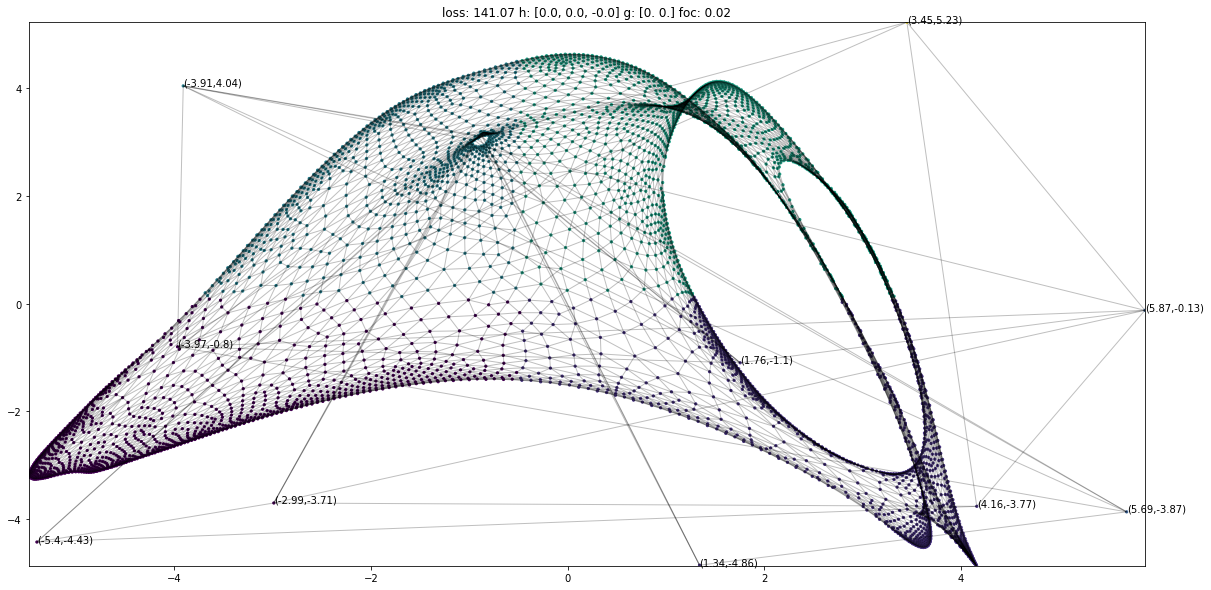

In [25]:
utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[-1],2)), [0.0,0.0,-0.0], np.round(gc,2), str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=voxel_id)
#utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[np.argmin(result['lossh'])],2)), np.round(hc,2), np.round(gc,2), str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=voxel_id)

In [ ]:
X_k = param_hist[9]
X_tst = np.zeros_like(X_k_n)
X_tst[:,0] = np.array(result['P'].T@X_k[:,0]) + result['n'][0].T
X_tst[:,1] = np.array(result['P'].T@X_k[:,1]) + result['n'][1].T
utils.plot_graph(X_tst, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[9],2)), np.round(hc,2), np.round(gc,2), str(np.round(result['foc'][9],2))), fixed_indices=fixed_indices, c=voxel_id)

In [ ]:
X_k = param_hist[10]
X_tst = np.zeros_like(X_k_n)
X_tst[:,0] = np.array(result['P'].T@X_k[:,0]) + result['n'][0].T
X_tst[:,1] = np.array(result['P'].T@X_k[:,1]) + result['n'][1].T
utils.plot_graph(X_tst, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[10],2)), np.round(hc,2), np.round(gc,2), str(np.round(result['foc'][10],2))), fixed_indices=fixed_indices, c=voxel_id)

In [ ]:
X_k = param_hist[11]
X_tst = np.zeros_like(X_k_n)
X_tst[:,0] = np.array(result['P'].T@X_k[:,0]) + result['n'][0].T
X_tst[:,1] = np.array(result['P'].T@X_k[:,1]) + result['n'][1].T
utils.plot_graph(X_tst, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[11],2)), np.round(hc,2), np.round(gc,2), str(np.round(result['foc'][11],2))), fixed_indices=fixed_indices, c=voxel_id)

In [ ]:
X_k = param_hist[12]
X_tst = np.zeros_like(X_k_n)
X_tst[:,0] = np.array(result['P'].T@X_k[:,0]) + result['n'][0].T
X_tst[:,1] = np.array(result['P'].T@X_k[:,1]) + result['n'][1].T
utils.plot_graph(X_tst, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[12],2)), np.round(hc,2), np.round(gc,2), str(np.round(result['foc'][12],2))), fixed_indices=fixed_indices, c=voxel_id)

In [ ]:
#pgd_soln = X_k_n

In [ ]:
"""
WORK IN PROGRESS BELOW 
"""

In [ ]:
#tst = np.random.uniform(-5,5,(10000,2))
#size = np.array([5, 5])
#voxel_id, voxel2bound = voxel_cluster(tst, size)
#plt.scatter(tst[:,0], tst[:,1], c=voxel_id)
#plt.colorbar()
#np.unique(voxel_id, return_index=True)[0]

In [ ]:
#unique_voxels, num_voxels_per_row

In [ ]:
"""
yo
"""

X_k = X_k_n
width = 10
size = np.array([width/2, width/2])

# levels
for _ in tqdm(range(2)): 
    size = size/2
    voxel_id, voxel2bound = voxel_cluster(X_k, size)
    unique_voxels, unique_vidx = np.unique(voxel_id, return_index=True)
    
    num_voxels_per_row = width/size[0]
    num_voxels=num_voxels_per_row**2
    
    for _ in range(5):
        np.random.shuffle(unique_vidx)
        
        for vidx in unique_vidx:
            vid = voxel_id[vidx]
            fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
            #fixed_indices = (~np.sum([clust_to_mask(voxel_id, vid), 
            #                          clust_to_mask(voxel_id, min(vid+1, num_voxels_per_row//(vid+1)*num_voxels_per_row))], axis=0).astype(bool)).astype(int) 
            #fixed_indices = (~np.sum([clust_to_mask(voxel_id, vid), 
            #                          clust_to_mask(voxel_id, min(vid+1, num_voxels_per_row//(vid+1)*num_voxels_per_row)),
            #                          clust_to_mask(voxel_id, min(vid+num_voxels_per_row, num_voxels)), 
            #                          clust_to_mask(voxel_id, min(vid+num_voxels_per_row+1, num_voxels))], axis=0).astype(bool)).astype(int) 

            if (1-fixed_indices).sum() < 4:
                continue

            num_move = (1-fixed_indices).sum()
            cc1 = num_move*size[0]**2*1/12
            cc2 = num_move*size[1]**2*1/12
            #cc1 = num_move*(2*size[0])**2*1/12
            #cc2 = num_move*(2*size[1])**2*1/12
            cc3 = 0

            C = jnp.block([[cc1, cc3],[cc3, cc2]])

            offset = (np.max(X_k,axis=0) - np.min(X_k,axis=0))/2
            centroid = voxel2bound[vidx]*size + size/2 - offset
            #centroid = jax.ops.index_add(centroid, 0, size[0]/2)
            #centroid = voxel2bound[vidx]*size - offset
            #centroid = np.mean(X_k[(1-fixed_indices)],axis=0)

            method = "pgd"
            if method == "pgd":
                opt_init, opt_update, get_params = padam(1e-2, partial(lambda x, y: project(y,x),C), 
                                                         b1=0.9, b2=0.999, eps=1e-08)
            elif method == "pnd":
                opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


            result = cluster(rng, (opt_init, opt_update, get_params), 
                             X_k, L, np.where(fixed_indices)[0], maxiters=1000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                             centercons=num_move*centroid, v=None, D=None, eps=1e-8, 
                             convergence_criterion=1e-3, method=method)

            results.append(result)
            X_k = result['x']
            gc = result['g']
            hc = result['h']
            loss = result['lossh']
            #param_hist.extend(result['sln_path'])
            print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))   


In [ ]:
utils.plot_graph(X_k, graph, c=voxel_id,title=str(np.round(wl(X_k, A, A),3)))

In [ ]:
"""
Generate animation frames
"""

dir = './frames'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

plt.figure(figsize=(20,10))
ax = plt.axes()

for l, result in enumerate(results):
    param_hist = result['sln_path']
    idx = np.linspace(0, len(param_hist)-1, num=100,dtype=int)
    #P_x, P_y = result['P']
    P_tmp = result['P']
    P_x_tmp = P_tmp
    P_y_tmp = P_tmp
    n0_x_tmp, n0_y_tmp = result['n']
    for k in idx:
        X_k_tmp = param_hist[k]

        X_k_n_tmp = np.zeros((n0_x_tmp.shape[0],2))
        X_k_n_tmp[:,0] = np.array(P_x_tmp.T@X_k_tmp[:,0]) + n0_x_tmp.T
        X_k_n_tmp[:,1] = np.array(P_y_tmp.T@X_k_tmp[:,1]) + n0_y_tmp.T
        positions_tmp = X_k_n_tmp

        ax.clear()
        
        ax = utils.plot_graph(X_k_n_tmp, graph, c=voxel_id)
        
        plt.savefig('./frames/{}_{}.png'.format(l, k))
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
"""
save animation as gif
"""
# filepaths
fp_in = "./frames/*.png"
fp_out = "./frames/animation.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in),key=os.path.getmtime)]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)

In [ ]:
_, unique_vidx = np.unique(voxel_id, return_index=True)
X_k = X_k_n
#opt_init, opt_update, get_params = padam(1e-1,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
#opt_init, opt_update, get_params = padam(1e-1,lambda x: x, b1=0.9, b2=0.999, eps=1e-08)

for vidx in unique_vidx:
    vid = voxel_id[vidx]
    fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
    #if (1-fixed_indices).sum() < 100:
    #    continue
    
    num_move = (1-fixed_indices).sum()
    cc1 = num_move*size[0]**2*1/12
    cc2 = num_move*size[1]**2*1/12
    cc3 = 0
    
    C = jnp.block([[cc1, cc3],[cc3, cc2]])
        
    offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
    centroid = voxel2bound[vidx]*size + size/2 - offset
    
    #opt_init, opt_update, get_params = padam(1e-4,partial(lambda x, y, z: project(z, x, y), C, centroid), 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    #opt_init, opt_update, get_params = padam(1e-2,lambda x : x, 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


    result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)
    results.append(result)
    X_k = result['x']
    gc = result['g']
    hc = result['h']
    loss = result['lossh']
    #param_hist.extend(result['sln_path'])
    print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))    

In [ ]:
"""BFS"""

def BFS(i, maxdepth, X_k, results):
    if i > maxdepth:
        return results
    size = np.array([10, 10])
    voxel_id, voxel2bound = voxel_cluster(X_k_n, size)
    _, unique_vidx = np.unique(voxel_id, return_index=True)
    
    for vidx in unique_vidx:
        vid = voxel_id[vidx]
        fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)

        num_move = (1-fixed_indices).sum()
        cc1 = num_move*size[0]**2*1/12
        cc2 = num_move*size[1]**2*1/12
        cc3 = 0

        C = jnp.block([[cc1, cc3],[cc3, cc2]])

        offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
        centroid = voxel2bound[vidx]*size + size/2 - offset

        result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)

        results.append(result)
        X_k = result['x']
        gc = result['g']
        hc = result['h']
        loss = result['lossh']

        print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))

        DFS(i+1, maxdepth, X_k, results)

In [ ]:
import tensorflow as tf
def load_cifar():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train.reshape(x_train.shape[0], -1) / 255
    x_test = x_test.reshape(x_test.shape[0], -1) / 255
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_cifar()

In [ ]:
"""
val_acc = np.load('/home/orange3xchicken/Downloads/L2SPL_val_acc.npy')
#tr_acc = np.load('/home/orange3xchicken/Downloads/L2SPL_train_acc.npy')
model_loss = np.load('/home/orange3xchicken/Downloads/meta_model_loss.npy')
meta_model_loss = np.load('/home/orange3xchicken/Downloads/meta_model_loss.npy')
adv_acc = [46.040, 45.200, 46.350, 46.450, 45.140, 47.250, 45.370, 44.350, 45.750, 47.120, 45.750, 44.270, 44.050, 41.650, 47.670, 46.300, 46.930, 43.700 , 53.750 , 54.580 , 54.570, 54.680, 54.760 ,  54.600, 54.690, 54.690 , 54.670 , 54.350 , 54.640 ,54.190, 54.470, 54.320 ,54.070,  53.300, 53.230 , 52.920, 53.170, 52.900, 52.850, 52.020, 52.080, 51.580 , 51.230,  50.920 ,50.930,50.530 ,50.310 ,50.390,49.730,49.950]
"""

In [ ]:
#plt.title('CIFAR-10 l-infty, eps=8/255 early stopping test accuracy: 86.91/57.84')
#plt.plot(val_acc[:,1] + np.random.normal(0,1,size=(50,)), label='clean test accuracy')
#plt.plot(adv_acc, label='adversarial test accuracy')

In [ ]:
#plt.title('CIFAR-10 l-infty, eps=8/255 early stopping test accuracy: 86.89/57.86')
#plt.plot(val_acc[:,1], label='clean test accuracy')
#plt.plot(adv_acc, label='adversarial test accuracy')

In [ ]:
#plt.title('CIFAR-10 l-infty, eps=8/255 early stopping test error: 13.11/42.14')
#plt.plot(100 -val_acc[:,1], label='clean test error')
#plt.plot(100- np.array(adv_acc), label='adversarial test error')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable
import torch.nn.init as init


def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)


class MetaModule(nn.Module):
    # adopted from: Adrien Ecoffet https://github.com/AdrienLE
    def params(self):
        for name, param in self.named_params(self):
            yield param

    def named_leaves(self):
        return []

    def named_submodules(self):
        return []

    def named_params(self, curr_module=None, memo=None, prefix=''):
        if memo is None:
            memo = set()

        if hasattr(curr_module, 'named_leaves'):
            for name, p in curr_module.named_leaves():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
        else:
            for name, p in curr_module._parameters.items():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p

        for mname, module in curr_module.named_children():
            submodule_prefix = prefix + ('.' if prefix else '') + mname
            for name, p in self.named_params(module, memo, submodule_prefix):
                yield name, p

    def update_params(self, lr_inner, first_order=False, source_params=None, detach=False):
        if source_params is not None:
            for tgt, src in zip(self.named_params(self), source_params):
                name_t, param_t = tgt
                # name_s, param_s = src
                # grad = param_s.grad
                # name_s, param_s = src
                grad = src
                if first_order:
                    grad = to_var(grad.detach().data)
                tmp = param_t - lr_inner * grad
                self.set_param(self, name_t, tmp)
        else:

            for name, param in self.named_params(self):
                if not detach:
                    grad = param.grad
                    if first_order:
                        grad = to_var(grad.detach().data)
                    tmp = param - lr_inner * grad
                    self.set_param(self, name, tmp)
                else:
                    param = param.detach_()  # https://blog.csdn.net/qq_39709535/article/details/81866686
                    self.set_param(self, name, param)

    def set_param(self, curr_mod, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in curr_mod.named_children():
                if module_name == name:
                    self.set_param(mod, rest, param)
                    break
        else:
            setattr(curr_mod, name, param)

    def detach_params(self):
        for name, param in self.named_params(self):
            self.set_param(self, name, param.detach())

    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = to_var(param.data.clone(), requires_grad=True)
            self.set_param(name, param)


class MetaLinear(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)

        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))

    def forward(self, x):
        return F.linear(x, self.weight, self.bias)

    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]


class MetaConv2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Conv2d(*args, **kwargs)

        self.in_channels = ignore.in_channels
        self.out_channels = ignore.out_channels
        self.stride = ignore.stride
        self.padding = ignore.padding
        self.dilation = ignore.dilation
        self.groups = ignore.groups
        self.kernel_size = ignore.kernel_size

        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))

        if ignore.bias is not None:
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        else:
            self.register_buffer('bias', None)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]


class MetaConvTranspose2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.ConvTranspose2d(*args, **kwargs)

        self.stride = ignore.stride
        self.padding = ignore.padding
        self.dilation = ignore.dilation
        self.groups = ignore.groups

        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))

        if ignore.bias is not None:
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        else:
            self.register_buffer('bias', None)

    def forward(self, x, output_size=None):
        output_padding = self._output_padding(x, output_size)
        return F.conv_transpose2d(x, self.weight, self.bias, self.stride, self.padding,
                                  output_padding, self.groups, self.dilation)

    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]


class MetaBatchNorm2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.BatchNorm2d(*args, **kwargs)

        self.num_features = ignore.num_features
        self.eps = ignore.eps
        self.momentum = ignore.momentum
        self.affine = ignore.affine
        self.track_running_stats = ignore.track_running_stats

        if self.affine:
            self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))

        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_var', torch.ones(self.num_features))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)

    def forward(self, x):
        return F.batch_norm(x, self.running_mean, self.running_var, self.weight, self.bias,
                            self.training or not self.track_running_stats, self.momentum, self.eps)

    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]


class MetaBasicBlock(MetaModule):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(MetaBasicBlock, self).__init__()

        self.bn1 = MetaBatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = MetaConv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = MetaBatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = MetaConv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and MetaConv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class MetaNetworkBlock(MetaModule):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(MetaNetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(MetaModule):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = MetaBasicBlock
        # 1st conv before any network block
        self.conv1 = MetaConv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = MetaNetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = MetaNetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = MetaNetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = MetaBatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = MetaLinear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, MetaConv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, MetaBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, MetaLinear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)



class VNet(MetaModule):
    def __init__(self, input, hidden, output):
        super(VNet, self).__init__()
        self.linear1 = MetaLinear(input, hidden)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = MetaLinear(hidden, output)



    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.linear2(x)
        return F.sigmoid(out)